<h3 style='color:blue' align='center'>Customer Churn Prediction Using Artificial Neural Network (ANN)</h3>

Customer churn prediction is to measure why customers are leaving a business. In this tutorial we will be looking at customer churn in telecom business. We will build a deep learning model to predict the churn and use precision,recall, f1-score to measure performance of our model

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

**Load the data**

In [4]:
df = pd.read_csv("customer_churn.csv")
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
521,4109-CYRBD,Male,1,Yes,No,29,Yes,Yes,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,51.60,1442,No
48,7639-LIAYI,Male,0,No,No,52,Yes,Yes,DSL,Yes,...,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),79.75,4217.8,No
1153,8777-PVYGU,Female,0,Yes,No,52,Yes,No,DSL,Yes,...,Yes,No,Yes,No,One year,Yes,Mailed check,64.30,3410.6,No
3212,0585-EGDDA,Male,0,Yes,No,40,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,80.00,3168.75,No
5635,2087-QAREY,Female,0,Yes,No,22,Yes,No,DSL,No,...,Yes,No,No,No,Month-to-month,Yes,Mailed check,54.70,1178.75,No


**First of all, drop customerID column as it is of no use**

In [7]:
df.drop('customerID',axis='columns',inplace=True)

In [9]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

**Quick glance at above makes me realize that TotalCharges should be float but it is an object. Let's check what's going on with  this column**

In [12]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

**Ahh... it is string. Lets convert it to numbers**

In [15]:
pd.to_numeric(df.TotalCharges)

ValueError: Unable to parse string " " at position 488

**Hmmm... some values seems to be not numbers but blank string. Let's find out such rows**

In [17]:
pd.to_numeric(df.TotalCharges,errors='coerce').isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [19]:
df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [21]:
df.shape

(7043, 20)

In [23]:
df.iloc[488].TotalCharges

' '

In [25]:
df[df.TotalCharges!=' '].shape

(7032, 20)

**Remove rows with space in TotalCharges**

In [28]:
df1 = df[df.TotalCharges!=' ']
df1.shape

(7032, 20)

In [30]:
df1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [32]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

C:\Users\suraj\AppData\Local\Temp\ipykernel_7572\973151263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.TotalCharges = pd.to_numeric(df1.TotalCharges)


In [34]:
df1.TotalCharges.values

array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

In [36]:
df1[df1.Churn=='No']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


**Data Visualization**

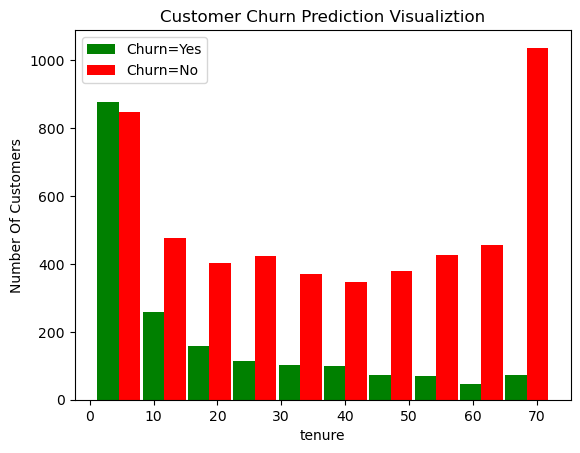

In [47]:
tenure_churn_no = df1[df1.Churn=='No'].tenure
tenure_churn_yes = df1[df1.Churn=='Yes'].tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

blood_sugar_men = [113, 85, 90, 150, 149, 88, 93, 115, 135, 80, 77, 82, 129]
blood_sugar_women = [67, 98, 89, 120, 133, 150, 84, 69, 89, 79, 120, 112, 100]

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=.95, color=['green','red'],label=['Churn=Yes','Churn=No'])
plt.legend()
plt.show()

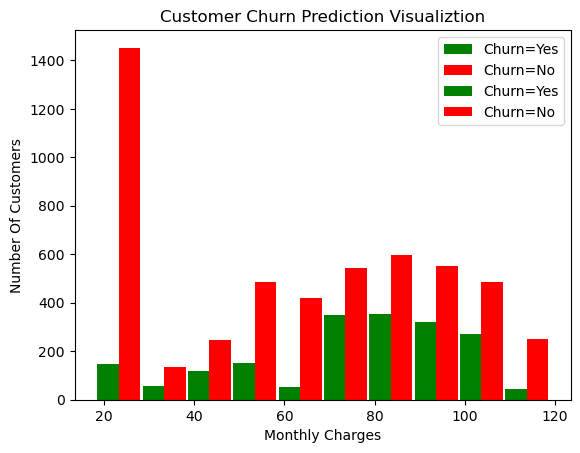

In [51]:
mc_churn_no = df1[df1.Churn=='No'].MonthlyCharges      
mc_churn_yes = df1[df1.Churn=='Yes'].MonthlyCharges      

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

blood_sugar_men = [113, 85, 90, 150, 149, 88, 93, 115, 135, 80, 77, 82, 129]
blood_sugar_women = [67, 98, 89, 120, 133, 150, 84, 69, 89, 79, 120, 112, 100]

plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['green','red'],label=['Churn=Yes','Churn=No'])
plt.legend()
plt.show()

**Many of the columns are yes, no etc. Let's print unique values in object columns to see data values**

In [53]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}') 

In [55]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Some of the columns have no internet service or no phone service, that can be replaced with a simple No**

In [58]:
df1.replace('No internet service','No',inplace=True)
df1.replace('No phone service','No',inplace=True)

C:\Users\suraj\AppData\Local\Temp\ipykernel_7572\2045096646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No internet service','No',inplace=True)
C:\Users\suraj\AppData\Local\Temp\ipykernel_7572\2045096646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No phone service','No',inplace=True)


In [60]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Convert Yes and No to 1 or 0**

In [63]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

C:\Users\suraj\AppData\Local\Temp\ipykernel_7572\1648037665.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1[col].replace({'Yes': 1,'No': 0},inplace=True)
C:\Users\suraj\AppData\Local\Temp\ipykernel_7572\1648037665.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1[col].replace({'Yes': 1

In [65]:
for col in df1:
    print(f'{col}: {df1[col].unique()}') 

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


In [67]:
df1['gender'].replace({'Female':1,'Male':0},inplace=True)

C:\Users\suraj\AppData\Local\Temp\ipykernel_7572\698335744.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['gender'].replace({'Female':1,'Male':0},inplace=True)
C:\Users\suraj\AppData\Local\Temp\ipykernel_7572\698335744.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['gender'].replac

In [69]:
df1.gender.unique()

array([1, 0], dtype=int64)

**One hot encoding for categorical columns**

In [72]:
df2 = pd.get_dummies(data=df1, columns=['InternetService','Contract','PaymentMethod'])
df2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [74]:
df2.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6313,0,0,0,0,2,1,0,0,0,1,...,False,True,False,True,False,False,False,False,True,False
5814,0,0,0,0,16,1,0,0,0,0,...,False,False,True,True,False,False,False,True,False,False
722,1,0,1,1,4,1,1,0,0,0,...,False,True,False,True,False,False,False,False,True,False
3494,1,0,1,1,9,1,1,0,0,0,...,False,True,False,True,False,False,True,False,False,False
1867,1,0,0,0,3,1,0,0,1,0,...,False,True,False,True,False,False,False,False,True,False


In [76]:
df2.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                           bool
InternetService_Fiber optic                   bool
InternetService_No             

In [78]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [80]:
for col in df2:
    print(f'{col}: {df2[col].unique()}')

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

**Train test split**

In [83]:
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [84]:
X_train.shape

(5625, 26)

In [87]:
X_test.shape

(1407, 26)

In [89]:
X_train[:10]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5664,1,1,0,0,0.126761,1,0,0,0,1,...,False,True,False,True,False,False,False,True,False,False
101,1,0,1,1,0.000000,1,0,0,0,0,...,False,False,True,True,False,False,False,False,True,False
2621,0,0,1,0,0.985915,1,0,0,1,1,...,True,False,False,False,False,True,False,True,False,False
392,1,1,0,0,0.014085,1,0,0,0,0,...,True,False,False,True,False,False,False,False,True,False
1327,0,0,1,0,0.816901,1,1,0,0,1,...,False,True,False,False,True,False,True,False,False,False
3607,1,0,0,0,0.169014,1,0,1,0,0,...,True,False,False,False,True,False,False,False,False,True
2773,0,0,1,0,0.323944,0,0,0,0,1,...,True,False,False,True,False,False,False,False,True,False
1936,1,0,1,0,0.704225,1,0,1,1,0,...,True,False,False,False,True,False,True,False,False,False
5387,0,0,0,0,0.042254,0,0,0,0,0,...,True,False,False,True,False,False,False,False,True,False
4331,0,0,0,0,0.985915,1,1,0,0,0,...,False,False,True,False,False,True,True,False,False,False


In [91]:
len(X_train.columns)

26

**Build a model (ANN) in tensorflow/keras**

In [94]:
import tensorflow as tf
from tensorflow import keras


model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(26,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)

D:\Apps_Download\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7687 - loss: 0.4955
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7940 - loss: 0.4295
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8007 - loss: 0.4192
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8037 - loss: 0.4138
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8078 - loss: 0.4110
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8096 - loss: 0.4085
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8096 - loss: 0.4070
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8108 - loss: 0.4051
Epoch 9/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8144 - loss: 0.4040
Epoch 10/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8132 - loss: 0.4028
Epoch 11/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8137 - loss: 0.4000
Epoch 12/100
176/176 ━━━━━━━━━━━━━━━━━━━━

In [96]:
model.evaluate(X_test, y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7775 - loss: 0.4897


[0.48971620202064514, 0.7775408625602722]

In [98]:
yp = model.predict(X_test)
yp[:5]

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[0.28187373],
       [0.67026174],
       [0.00540212],
       [0.8620019 ],
       [0.46475756]], dtype=float32)

In [100]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [102]:
y_pred[:10]

[0, 1, 0, 1, 0, 1, 0, 0, 0, 0]

In [104]:
y_test[:10]

2660    0
744     0
5579    1
64      1
3287    1
816     1
2670    0
5920    0
1023    0
6087    0
Name: Churn, dtype: int64

In [106]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       999
           1       0.65      0.51      0.57       408

    accuracy                           0.78      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.77      0.78      0.77      1407



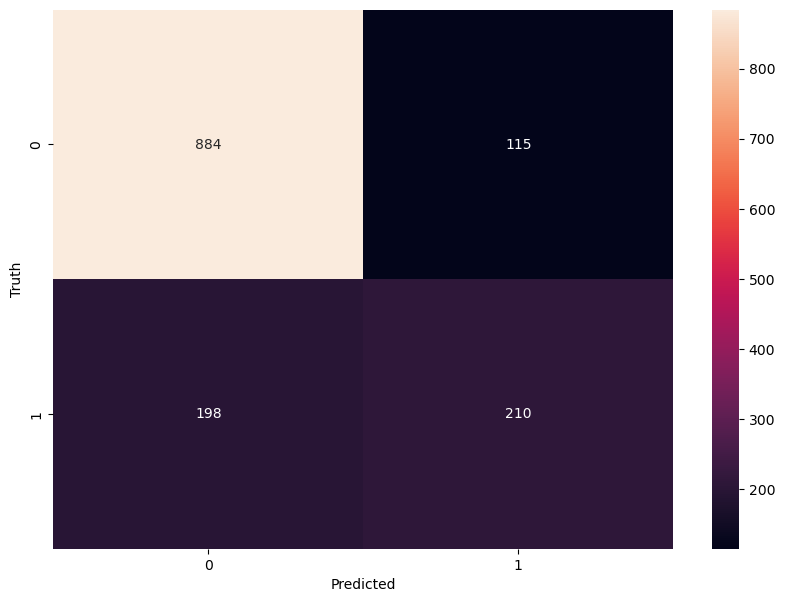

In [112]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [114]:
y_test.shape

(1407,)

**Accuracy**

In [117]:
round((862+229)/(862+229+137+179),2)

0.78

**Precision for 0 class. i.e. Precision for customers who did not churn**

In [120]:
round(862/(862+179),2)

0.83

**Precision for 1 class. i.e. Precision for customers who actually churned**

In [123]:
round(229/(229+137),2)

0.63

**Recall for 0 class**

In [126]:
round(862/(862+137),2)

0.86

In [128]:
round(229/(229+179),2)

0.56

**Exercise**

In [131]:
Take this dataset for bank customer churn prediction : https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

1) Build a deep learning model to predict churn rate at bank. 

2) Once model is built, print classification report and analyze precision, recall and f1-score 

SyntaxError: unmatched ')' (2771018380.py, line 3)

In [143]:
# Class count 
count_class_0, count_class_1 = df1.Churn.value_counts()

# Devided by class
df_class_0 = df2[df2['Churn'] == 0]
df_class_1 = df2[df2['Churn'] == 1]

In [145]:
count_class_0, count_class_1

(5163, 1869)

In [149]:
df_class_0.shape

(5163, 27)

In [151]:
df_class_0_under = df_class_0.sample(count_class_1)

In [153]:
df_test_under = pd.concat([df_class_0_under,df_class_1],axis=0)

print('Random under-sampling:')
print(df_test_under.Churn.value_counts())

Random under-sampling:
Churn
0    1869
1    1869
Name: count, dtype: int64


In [155]:
X = df_test_under.drop('Churn',axis='columns')
y = df_test_under['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [157]:
# Number of classes in training Data
y_train.value_counts()

Churn
0    1495
1    1495
Name: count, dtype: int64

In [159]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(26, input_dim=26, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight = weights)
    
    print(model.evaluate(X_test, y_test))
    
    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)
    
    print("Classification Report: \n", classification_report(y_test, y_preds))
    
    return y_preds

In [161]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

D:\Apps_Download\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6431 - loss: 0.6355
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7462 - loss: 0.5284
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7579 - loss: 0.5057
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7538 - loss: 0.5008
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7602 - loss: 0.4973
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7552 - loss: 0.4929
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7599 - loss: 0.4930
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7605 - loss: 0.4892
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7629 - loss: 0.4871
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7656 - loss: 0.4859
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7679 - loss: 0.4830
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy:

## METHOD 2. OVER SAMPLING

In [164]:
# Oversample 1-class and concat the DataFrames of both classes
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Churn.value_counts())

Random over-sampling:
Churn
0    5163
1    5163
Name: count, dtype: int64


In [166]:
X = df_test_over.drop('Churn',axis='columns')
y = df_test_over['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)


In [168]:
# Number of classes in training Data
y_train.value_counts()

Churn
1    4130
0    4130
Name: count, dtype: int64

In [170]:
loss = keras.losses.BinaryCrossentropy()
weights = -1
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100


D:\Apps_Download\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7157 - loss: 0.5622
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7599 - loss: 0.4993
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7613 - loss: 0.4877
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7640 - loss: 0.4823
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7667 - loss: 0.4784
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7686 - loss: 0.4749
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7730 - loss: 0.4724
Epoch 8/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7713 - loss: 0.4698
Epoch 9/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7728 - loss: 0.4665
Epoch 10/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7747 - loss: 0.4642
Epoch 11/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7743 - loss: 0.4624
Epoch 12/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

## METHOD3 : SMOTE

In [172]:
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

In [177]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts()

Churn
0    5163
1    5163
Name: count, dtype: int64

In [179]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [181]:
# Number of classes in training Data
y_train.value_counts()

Churn
1    4130
0    4130
Name: count, dtype: int64

In [183]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100


D:\Apps_Download\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7493 - loss: 0.5287
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7791 - loss: 0.4657
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7855 - loss: 0.4578
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7855 - loss: 0.4533
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7902 - loss: 0.4475
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7913 - loss: 0.4429
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7930 - loss: 0.4400
Epoch 8/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7947 - loss: 0.4363
Epoch 9/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7953 - loss: 0.4339
Epoch 10/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7987 - loss: 0.4298
Epoch 11/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8005 - loss: 0.4275
Epoch 12/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

## METHOD4: USE OF ENSAMBLE WITH UNDERSampling

In [185]:
# Regain Original features and labels
X = df2.drop('Churn',axis='columns')
y = df2['Churn']

In [186]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [187]:
y_train.value_counts()

Churn
0    4130
1    1495
Name: count, dtype: int64

In [192]:
df3 = X_train.copy()
df3['Churn'] = y_train

In [194]:
df3_class0 = df3[df3.Churn==0]
df3_class1 = df3[df3.Churn==1]

In [196]:
def get_train_batch(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)

    X_train = df_train.drop('Churn', axis='columns')
    y_train = df_train.Churn
    return X_train, y_train  

In [198]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 0, 1495)

y_pred1 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100


D:\Apps_Download\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6589 - loss: 0.6477
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7498 - loss: 0.5337
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7592 - loss: 0.5033
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7645 - loss: 0.4920
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7679 - loss: 0.4868
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7686 - loss: 0.4822
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7709 - loss: 0.4809
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7686 - loss: 0.4784
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7706 - loss: 0.4778
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7726 - loss: 0.4748
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7726 - loss: 0.4739
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7763 - lo

In [200]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 1495, 2990)

y_pred2 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100


D:\Apps_Download\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6702 - loss: 0.6170
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7498 - loss: 0.5134
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7589 - loss: 0.4938
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7609 - loss: 0.4876
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7615 - loss: 0.4856
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7619 - loss: 0.4814
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7612 - loss: 0.4784
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7679 - loss: 0.4749
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7679 - loss: 0.4734
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7666 - loss: 0.4727
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7679 - loss: 0.4701
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7676 - lo

In [202]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 2990, 4130)

y_pred3 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100


D:\Apps_Download\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6417 - loss: 0.6433
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7579 - loss: 0.5222
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7704 - loss: 0.4921
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7685 - loss: 0.4823
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7750 - loss: 0.4748
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7818 - loss: 0.4705
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7791 - loss: 0.4675
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7833 - loss: 0.4639
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7894 - loss: 0.4613
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7905 - loss: 0.4590
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7875 - loss: 0.4576
Epoch 12/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7890 - lo

In [204]:
y_pred3

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [206]:
y_pred_final = y_pred1.copy()
for i in range(len(y_pred1)):
    n_ones = y_pred1[i] + y_pred2[i] + y_pred3[i]
    if n_ones>1:
        y_pred_final[i] = 1
    else:
        y_pred_final[i] = 0

In [208]:
cl_rep = classification_report(y_test, y_pred_final)
print(cl_rep)

              precision    recall  f1-score   support

           0       0.90      0.69      0.78      1033
           1       0.48      0.79      0.59       374

    accuracy                           0.71      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.71      0.73      1407

